# **Natural Language Processing**



The goal of this assigment is to conduct Sentiment Analysis via Shallow ML

Set up environment

In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
print(datetime.datetime.now())

2022-05-02 22:02:07.084761


In [3]:
!which python

/usr/local/bin/python


In [4]:
!python --version

Python 3.7.13


In [5]:
!echo $PYTHONPATH

/env/python


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import string
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from bs4 import BeautifulSoup

import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [7]:
from sklearn.metrics import f1_score

In [8]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [9]:
df.head()

,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [10]:
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

##Preprocessing and FE Pipeline


In [11]:
pip install Unidecode

     |████████████████████████████████| 235 kB 4.4 MB/s 


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup
import unidecode

stop_words = set(stopwords.words('english'))

lemmer = WordNetLemmatizer()

def preprocess(x):
    # Remove HTML tags
    x = BeautifulSoup(x, "lxml").get_text()

    # Lower case
    x = x.lower()
    
    # Remove punctuation
    x = re.sub(r'[^\w\s]', '', x)
    
    # Remove non-unicode
    x = unidecode.unidecode(x)
    
    # Remove numbers
    x = re.sub(r'\d+', '', x)
    
    # Remove stopwords and lemmatize
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]
    return ' '.join(x) 

%time X_train_clean = X_train.apply(preprocess)
X_train_clean.head()

CPU times: user 2.59 s, sys: 166 ms, total: 2.76 s
Wall time: 3.08 s


2072    crackle unpredictable youthful energy honestly...
630     four star food guy blue shirt great vibe still...
963     rave review couldnt wait eat herewhat disappoi...
1606            overall would recommend phone new walkman
2185                                 highly unrecommended
Name: Sentence, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=.05, max_df=.5, ngram_range=[1,3])
%time dtm_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)

bow_df_tfidf = pd.DataFrame(dtm_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names(), index=X_train_clean.index)
bow_df_tfidf.shape

Xclean_bow_tfidf = pd.concat([X_train_clean, bow_df_tfidf], axis=1)
Xclean_bow_tfidf.shape
Xclean_bow_tfidf.head()

CPU times: user 62.7 ms, sys: 7.81 ms, total: 70.5 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(1800, 4)

(1800, 5)

,Sentence,food,good,great,phone
2072,crackle unpredictable youthful energy honestly...,0.000000,0.0,0.000000,0.0
630,four star food guy blue shirt great vibe still...,0.741531,0.0,0.670919,0.0
963,rave review couldnt wait eat herewhat disappoi...,0.000000,0.0,0.000000,0.0
1606,overall would recommend phone new walkman,0.000000,0.0,0.000000,1.0
2185,highly unrecommended,0.000000,0.0,0.000000,0.0


##Model Training/Tuning/Cross Validation



In [15]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf = ensemble.RandomForestClassifier()
score = cross_val_score(rf,dtm_tfidf,y_train,scoring="f1_micro",cv=5)
print(score)
score.mean()

[0.58333333 0.59722222 0.57777778 0.625      0.62222222]


0.6011111111111112

In [17]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators':[100, 200, 500], 
              'max_features':['auto','sqrt','log2'],
              'max_depth': [2, 5, 10, 20]}

cv = GridSearchCV(rf,param_grid,scoring="f1_micro",cv=5, verbose=1)
cv = cv.fit(bow_df_tfidf,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [18]:
print(cv.best_params_)

{'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100}


In [19]:
print(cv.best_score_)

0.6016666666666667


In [20]:
X_val_clean = X_val.apply(preprocess)

In [21]:
X_val_clean.head()

2037                                  buy play enjoy love
1978    fit securely ear hook even need used sound bet...
855       fella got huevos rancheros didnt look appealing
1719    simply want small flip phone look elsewhere ex...
2019    structure film easily tightly constructed hist...
Name: Sentence, dtype: object

In [22]:
X_val_vectorize = tfidf_vectorizer.transform(X_val_clean)

In [23]:
X_val_vectorize

<600x4 sparse matrix of type '<class 'numpy.float64'>'
	with 154 stored elements in Compressed Sparse Row format>

In [24]:
y_val_pred = cv.predict(X_val_vectorize)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [25]:
f1_score(y_val, y_val_pred, average='micro')

0.6333333333333333

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [27]:
confusion = confusion_matrix(y_val, y_val_pred)
print(confusion)
print(classification_report(y_val, y_val_pred))

[[311  12]
 [208  69]]
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       323
           1       0.85      0.25      0.39       277

    accuracy                           0.63       600
   macro avg       0.73      0.61      0.56       600
weighted avg       0.72      0.63      0.58       600



Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'Actual')

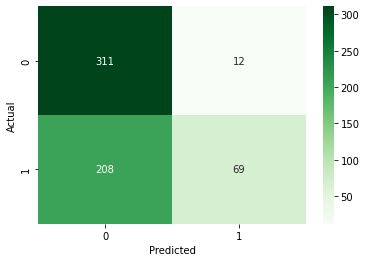

In [28]:
sns.heatmap(confusion, cmap='Greens', annot=True,
xticklabels=[0,1], yticklabels=[0,1], fmt='g' )
plt.xlabel ("Predicted" )
plt.ylabel("Actual")
plt.show()

##Model Assessment 

In [29]:
test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [30]:
test_df.head()

,Sentence,Polarity
0,A good commentary of today's love and undoubte...,1
1,For people who are first timers in film making...,1
2,"It was very popular when I was in the cinema, ...",1
3,It's a feel-good film and that's how I felt wh...,1
4,It has northern humour and positive about the ...,1


In [31]:
X_test = test_df['Sentence']
y_test = test_df['Polarity']

In [32]:
X_test_clean = X_test.apply(preprocess)

In [33]:
X_test_vectorize = tfidf_vectorizer.transform(X_test_clean)

In [34]:
y_test_pred = cv.predict(X_test_vectorize)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [35]:
f1_score(y_test, y_test_pred, average='micro')

0.5333333333333333

In [36]:
confusion = confusion_matrix(y_test, y_test_pred)
print(confusion)
print(classification_report(y_test, y_test_pred))

[[276  11]
 [269  44]]
              precision    recall  f1-score   support

           0       0.51      0.96      0.66       287
           1       0.80      0.14      0.24       313

    accuracy                           0.53       600
   macro avg       0.65      0.55      0.45       600
weighted avg       0.66      0.53      0.44       600



Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'Actual')

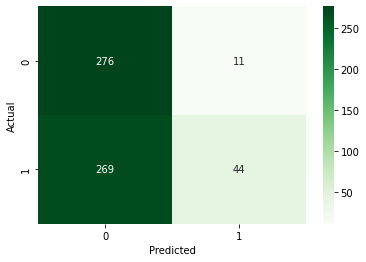

In [37]:
sns.heatmap(confusion, cmap='Greens', annot=True,
xticklabels=[0,1], yticklabels=[0,1], fmt='g' )
plt.xlabel ("Predicted" )
plt.ylabel("Actual")
plt.show()

##Five test instances in which the model was incorrect

In [38]:
df2 = pd.DataFrame(X_test, columns=['Sentence'])
df2['actual'] = y_test
df2['predicted'] = y_test_pred
incorrect = df2[df2['actual'] != df2['predicted']]

In [40]:
incorrect.head(5)

,Sentence,actual,predicted
1,For people who are first timers in film making...,1,0
3,It's a feel-good film and that's how I felt wh...,1,0
4,It has northern humour and positive about the ...,1,0
5,I rather enjoyed it.,1,0
6,I liked it.,1,0
